### Full Name : Pantea Amoie
### Student Number : 400101656


# CART Algorithm Implementation with MNIST Dataset

## Goal
The objective is to implement the Classification and Regression Trees (CART) algorithm from scratch and apply it to the MNIST dataset. After completing the implementation, you will compare its performance with scikit-learn's `DecisionTreeClassifier` and analyze the results through visualizations.

## Part 1: Data Preparation and Exploration

1. **Data Normalization**  
   - Normalize the data using **z-score normalization** to ensure that each feature has a mean of 0 and a standard deviation of 1.

2. **Data Visualization**
   a. Display 10 sample images from the **training set**, **validation set**, and **test set**.  
   b. Create a **histogram** showing the distribution of labels across the **training set**, **validation set**, and **test set**.

In [6]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import numpy as np

# I added this part to compute mean and std of the data, therefore I'll be able to
# use it in transforms.Normalize function.
# We could also use transforms.Normalize((0.5,), (0.5,)) which is common. For
# accurate normalization, however, it is generally better to use the mean and
# standard deviation of the specific dataset.

def calculate_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.0
    std = 0.0
    total_images_count = 0

    for images, _ in loader:
        images = images.view(images.size(0), -1)  # Flattening the images
        mean += images.mean(1).sum(0)
        std += images.std(1).sum(0)
        total_images_count += images.size(0)

    mean /= total_images_count
    std /= total_images_count

    return mean.item(), std.item()

# Loading MNIST without transformations to calculate mean and std
raw_mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
mean, std = calculate_mean_std(raw_mnist)

print(f"Mean: {mean}, Std: {std}")

def prepare_data(batch_size=64, train_ratio=0.8):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])

    full_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

    train_size = int(len(full_dataset) * train_ratio)
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.5MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 28.9k/28.9k [00:00<00:00, 348kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.20MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
<urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: certificate has expired (_ssl.c:1007)>



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.55MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Mean: 0.13066041469573975, Std: 0.30150410532951355


In [7]:
def explore_data(data_loader):
    # Get a batch of data
    images, labels = next(iter(data_loader))

    # Plot sample images
    fig, axes = plt.subplots(1, 10, figsize=(10, 2))
    for i in range(10):
        axes[i].imshow(images[i].squeeze(), cmap="gray") # We use squeez() to remove the channel dimension (1, 28, 28) -> (28, 28)
        axes[i].set_title(f"Label: {labels[i].item()}")
        axes[i].axis('off')
    plt.show()

    # Plot label distribution
    num_label = np.zeros(10) # num_labels represents the number of times each label has been seen in the batch
    for _, labels in data_loader:
        num_label += np.bincount(labels.numpy(), minlength=10) # bincount counts the number of times each value of the array is seen in the batch

    plt.figure()
    plt.bar(range(10), num_label, tick_label=range(10))
    plt.title(f'Label Distribution')
    plt.xlabel('Digits')
    plt.ylabel('Count')
    plt.show()


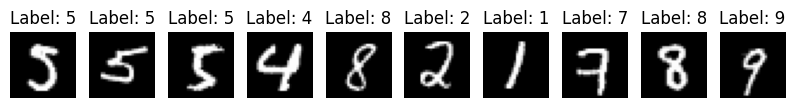

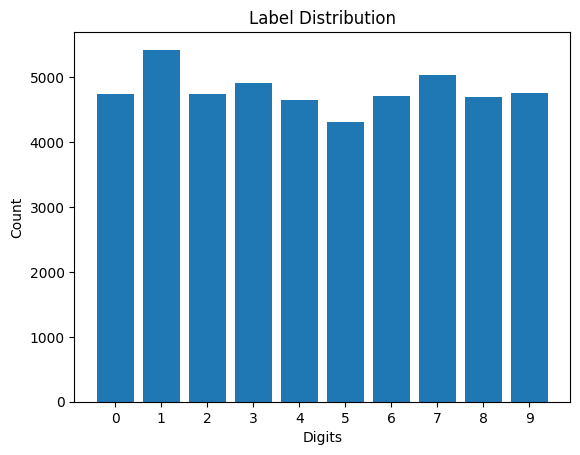

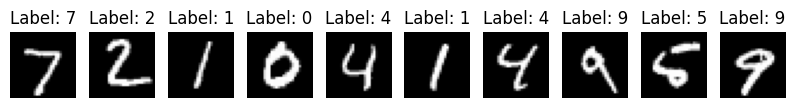

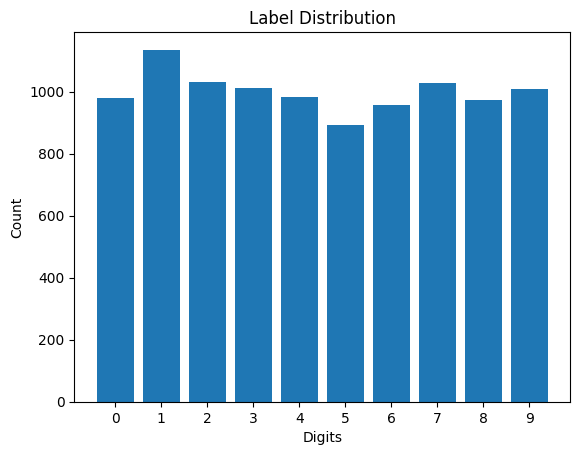

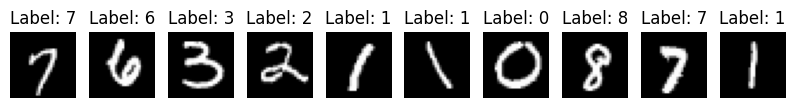

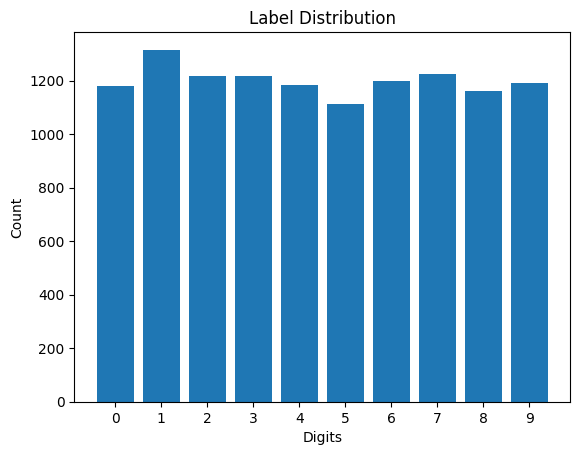

In [8]:
train_loader, val_loader, test_loader = prepare_data()
explore_data(train_loader)
explore_data(test_loader)
explore_data(val_loader)


Prepare the data for use with the CART algorithm by flattening the images.

In [9]:
def prepare_data_for_cart(data_loader):
    # CART algorithms usually work with 2D arrays of features where each row is a flattened image and each column is a pixel value
    # therefore, we need to flatten the images into 1D vectors

    flattened_images_arr = []
    labels_arr = []

    for images, labels in data_loader:
      flattened_images = images.view(images.size(0), -1) # (batch size, 1, 28, 28) -> (batch_size, 28*28 = 784)
      flattened_images_arr.append(flattened_images.numpy())  # to numpy array
      labels_arr.append(labels.numpy()) # to numpy array

    # We need to concatenate the arrays of images and labels for each batch into a single array that has all the images and labels for the entire dataset
    total_flattened_images = np.concatenate(flattened_images_arr, axis=0)
    total_labels = np.concatenate(labels_arr, axis=0)

    return total_flattened_images, total_labels

In [10]:
X_train, y_train = prepare_data_for_cart(train_loader)
X_val, y_val = prepare_data_for_cart(val_loader)
X_test, y_test = prepare_data_for_cart(test_loader)

## Part 2: CART Algorithm Implementation

1. Implement the CART algorithm from scratch, including:
   a. Node class to represent tree nodes
   b. DecisionTree class with the following methods:
      - `fit(X, y)`: Train the decision tree
      - `predict(X)`: Make predictions on new data
      - `_build_tree(X, y, depth)`: Recursively build the tree
      - `_find_best_split(X, y)`: Find the best feature and threshold for splitting
      - `_calculate_gini_impurity(y)`: Calculate Gini impurity for a set of labels
2. Your implementation should support the following hyperparameters:
   - `max_depth`: Maximum depth of the tree
   - `min_samples_split`: Minimum number of samples required to split an internal node

Note: Feel free to change, add, and remove functions.

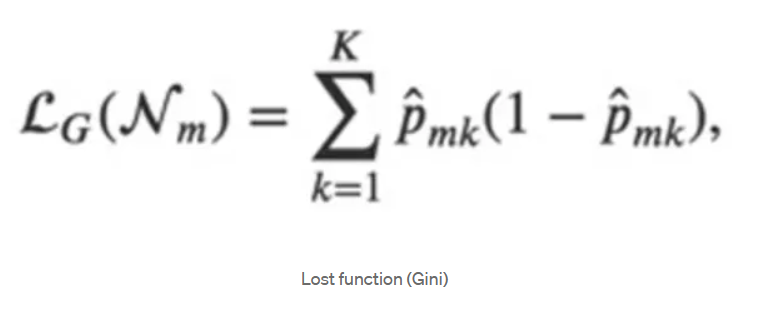

In [11]:
# من در این سوال از ویدیوی یوتیوب زیر برای فهم این الگوریتم استفاده کردم
# Decision and Classification Trees, Clearly Explained!!! (StatQuest with Josh Starmer)
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class DecisionTree_CART:
    def __init__(self, max_depth=10, min_samples_split=2):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y, depth=0):
        # Implement recursive tree building here

        if depth >= self.max_depth or len(set(y)) == 1 or len(X) < self.min_samples_split:
            # When our tree gets deeper than max_depth or when The remaining subset has too few samples to perform a meaningful split,
            # we should stop splitting and should create a leaf node with the value of the digit which is the more frequent
            return Node(value=np.bincount(y).argmax())

        feature, threshold = self._find_best_split(X, y)
        # If , for example, there are no features left to produce a meaningful split,
        # we again, stop splitting and create a leaf node
        if feature is None:
            return Node(value=np.bincount(y).argmax())
        sample_num, feature_num = X.shape

        # We use right and left boolean arrays as masks (to save the tree path of each sample)
        left_mask = X[:, feature] < threshold
        right_mask = ~left_mask

        # We slpit the data into left and right subsets, and the method recursively builds left and right subtrees
        left_node = self._build_tree(X[left_mask], y[left_mask], depth + 1)
        right_node = self._build_tree(X[right_mask], y[right_mask], depth + 1)

        return Node(feature=feature, threshold=threshold, left=left_node, right=right_node)


    def _find_best_split(self, X, y):
        # Implement best split finding here

        lowest_gini_impurity = float('inf')
        sample_num, feature_num = X.shape
        best_feature = None
        best_threshold = None

        for feature in range(feature_num):
            # Using this method takes a very long time to run:
            # thresholds = np.unique(X[:, feature]) # The feature values are the possible thresholds in our tree
            # This reduces the running time very much:
            thresholds = np.percentile(X[:, feature], np.linspace(0, 100, 10))
            for threshold in thresholds:
              # We use right and left boolean arrays as masks, to save the tree path of each sample
              left_mask = X[:, feature] < threshold
              right_mask = ~left_mask

              if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue
              left_gini_impurity = self._gini_impurity(y[left_mask])
              right_gini_impurity = self._gini_impurity(y[right_mask])

              # Total gini impurity = weighted avg of gini impurities for the leaves
              total_gini_impurity = (left_gini_impurity * (left_mask.sum() / len(y)) + right_gini_impurity * (right_mask.sum() / len(y)))

              if total_gini_impurity < lowest_gini_impurity:
                  lowest_gini_impurity = total_gini_impurity
                  best_feature = feature
                  best_threshold = threshold

        return best_feature, best_threshold



    def _gini_impurity(self, y):
        # Implement Gini impurity calculation here
        # Gini impurity = 1 - sigma (pi ^2)

        p_i = np.bincount(y) / len(y)
        gini_impurity = 1 - np.sum(p_i ** 2)
        return gini_impurity

    def predict(self, X):
        # Implement prediction here

        predictions = []
        for x in X:
            node = self.root
            # We should traverse the tree until we reach a leaf
            while node.left is not None and node.right is not None:
                if x[node.feature] < node.threshold:
                    node = node.left
                else:
                    node = node.right
            predictions.append(node.value) # Adding the leaf value to our predictions array

        return np.array(predictions)




## Part 3: Model Evaluation and Comparison

1. Train your CART implementation on the MNIST training data.
2. Evaluate your model's performance on the test set and report the accuracy.
3. Train scikit-learn's DecisionTreeClassifier on the same data.
4. Compare the performance of your implementation with scikit-learn's version.
5. Create a plot showing how accuracy changes with tree depth for both implementations.

In [13]:
X_train, y_train = prepare_data_for_cart(train_loader)

tree = DecisionTree_CART(max_depth=5)
tree.fit(X_train, y_train)

X_test, y_test = prepare_data_for_cart(test_loader)
predictions = tree.predict(X_test)

# Evaluating our model's performance on the test set and report the accuracy
accuracy = accuracy_score(y_test, predictions)
print(f"My CART Decision Tree Accuracy: {accuracy:.2f}")

# Training scikit-learn's DecisionTreeClassifier on the same data
scikitlearn_tree = DecisionTreeClassifier(max_depth=5)
scikitlearn_tree.fit(X_train, y_train)
scikitlearn_predictions = scikitlearn_tree.predict(X_test)

# Comparing the performances
scikitlearn_accuracy = accuracy_score(y_test, scikitlearn_predictions)
print(f"Scikit-learn Decision Tree Accuracy: {scikitlearn_accuracy:.2f}")

My CART Decision Tree Accuracy: 0.67
Scikit-learn Decision Tree Accuracy: 0.68


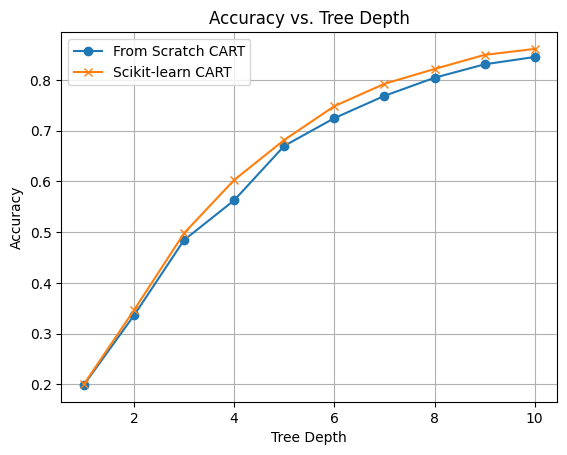

In [14]:
# Creating a plot showing how accuracy changes with tree depth for both implementations

depths = list(range(1, 11))
my_accuracies = []
sklearn_accuracies = []

for depth in depths:
    # From scratch CART
    tree = DecisionTree_CART(max_depth=depth)
    tree.fit(X_train, y_train)
    my_predictions = tree.predict(X_test)
    my_accuracies.append(accuracy_score(y_test, my_predictions))

    # Scikit-learn CART
    sklearn_tree = DecisionTreeClassifier(max_depth=depth)
    sklearn_tree.fit(X_train, y_train)
    sklearn_predictions = sklearn_tree.predict(X_test)
    sklearn_accuracies.append(accuracy_score(y_test, sklearn_predictions))

plt.plot(depths, my_accuracies, label='From Scratch CART', marker='o')
plt.plot(depths, sklearn_accuracies, label='Scikit-learn CART', marker='x')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Tree Depth')
plt.legend()
plt.grid(True)
plt.show()


As we can see, the accuracies of the two methods are close to eachother, but Scikit-learn CART seems to have a bit higher accuracies.

## Question
What is the difference between ID3 and CART algorithm

- ID3 is used only for classification problems, meaning it can only handle categorical target variables.
CART can be used for both classification and regression. For classification, it outputs class labels, and for regression, it predicts continuous values.
- ID3 uses information gain based on entropy to decide the best feature to split the data.
CART uses the Gini impurity for classification tasks and Mean Squared Error (MSE) for regression tasks to determine the best split.
- ID3 tends to be faster and more efficient when working with categorical data due to the simplicity of entropy-based splitting.
CART can be slower, especially for large datasets, as it requires more computational resources to calculate the Gini impurity or regression splits.
- ID3 can only create binary trees (each node has exactly two children).
CART also creates binary trees, but it can handle both continuous and categorical data, unlike ID3, which works best with categorical features.
- ID3 was originally designed to handle categorical features only. For continuous features, you would need to discretize the data.
CART handles continuous features natively by splitting based on thresholds (for example x < 5.5).
- ID3 does not explicitly involve pruning (though post-pruning methods can be applied after tree generation).
CART supports pruning as a part of its algorithm to avoid overfitting by trimming branches that contribute less to the accuracy of the tree.